In [26]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../python')
import plot_info
import json
import copy
import pprint

In [14]:
basename='../data/airfoils_qmc_{}.json'

In [15]:
functionals = ['Drag', 'Lift']

data = {}

for functional in functionals:
    data[functional] = []
    
    filename = basename.format(functional.lower())
    
    with open(filename, 'r') as f:
        json_content = json.load(f)
        
        data[functional] = copy.deepcopy(json_content)

[64, 128, 256, 32]


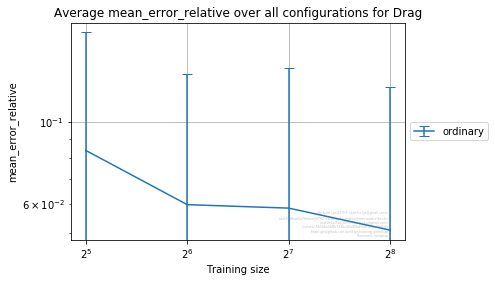

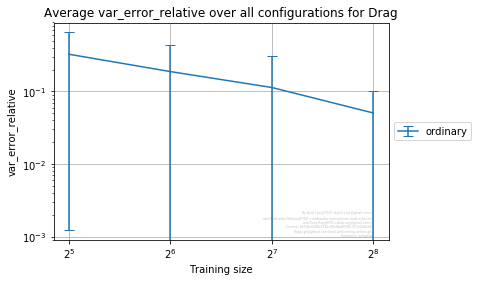

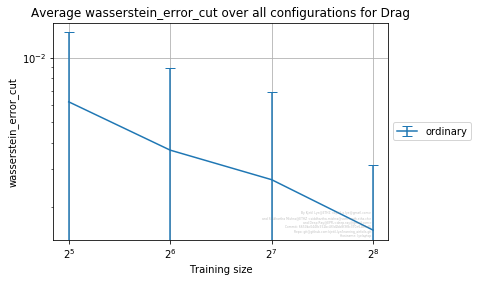

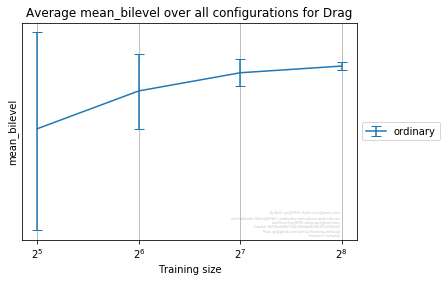

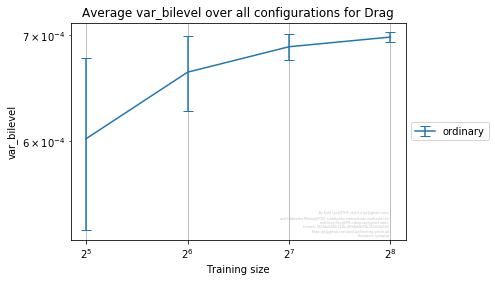

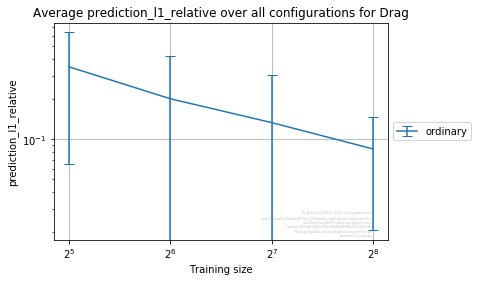

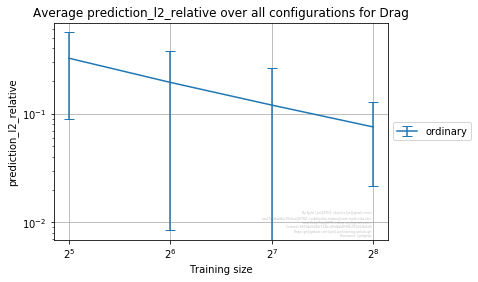

[64, 128, 256, 32]


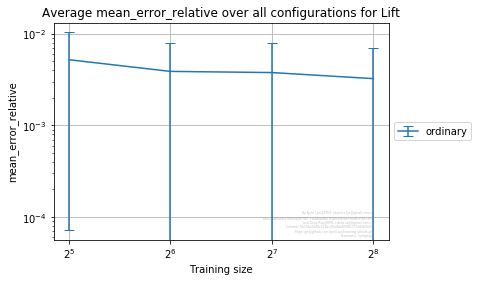

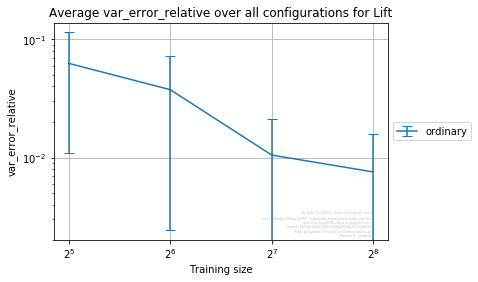

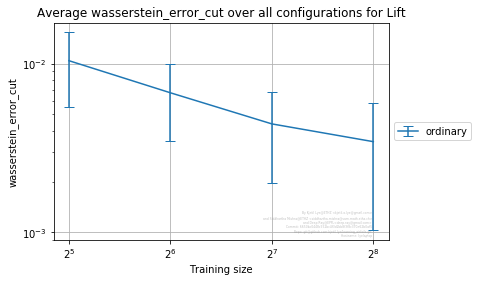

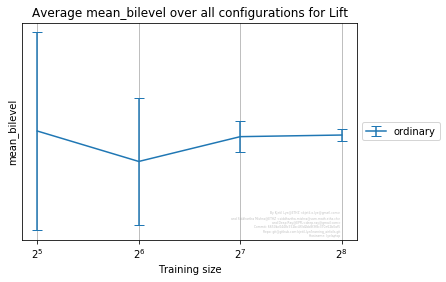

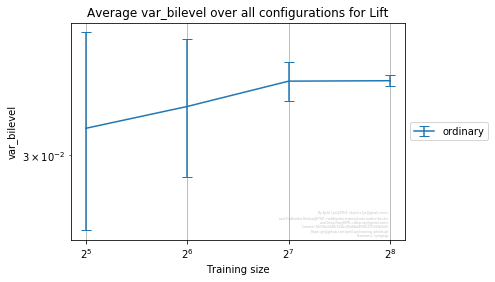

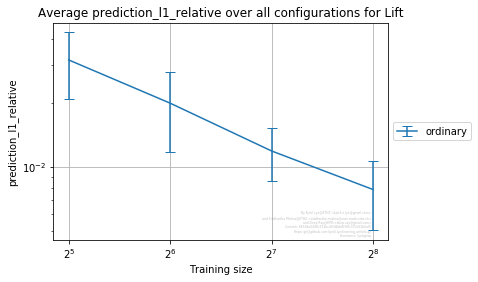

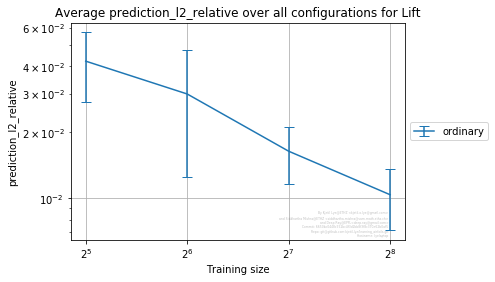

In [83]:
# As a function of training size
def plot_as_training_size(functional, data):
    train_sizes = []
    
    for configuration in data[functional]['configurations']:
        train_size = int(configuration['settings']['train_size'])
        if train_size not in train_sizes:
            train_sizes.append(train_size)
    print(train_sizes) 
    train_sizes = sorted(train_sizes)
    
    
    
    errors = {
        "mean_error_relative" : np.zeros(len(train_sizes)),
        "var_error_relative" : np.zeros(len(train_sizes)),
        "wasserstein_error_cut" : np.zeros(len(train_sizes)),
        "mean_bilevel":np.zeros(len(train_sizes)),
        "var_bilevel" :np.zeros(len(train_sizes)),
        "prediction_l1_relative": np.zeros(len(train_sizes)),
        "prediction_l2_relative" : np.zeros(len(train_sizes))
    }
    
    errors_var = {}
    errors_min = {}
    
    errors_max = {}
    for k in errors.keys():
        errors_var[k]  = np.zeros(len(train_sizes))
        errors_max[k]  = np.zeros(len(train_sizes))
        errors_min[k]  = np.zeros(len(train_sizes))
    for error in errors.keys():
        tactics=['ordinary']
        for tactic in tactics:
            for (n, train_size) in enumerate(train_sizes):
                errors_local = []
                for configuration in data[functional]['configurations']:
                    ts = int(configuration['settings']['train_size'])
                    if ts == train_size:
                        errors_local.append(configuration['results']['best_network']['algorithms']['QMC_from_data']['ml'][tactic][error])
                errors[error][n] = np.mean(errors_local)
                errors_var[error][n] = np.var(errors_local)
                errors_min[error][n] = np.amin(errors_local)
                errors_max[error][n] = np.amax(errors_local)
                
            p = plt.errorbar(train_sizes, errors[error], yerr=np.sqrt(errors_var[error]), label=tactic,
                            solid_capstyle='projecting', capsize=5)
            #plt.loglog(train_sizes, errors_min[error], '.--', label='{} minimum'.format(tactic), color=p[0].get_color())
            #plt.loglog(train_sizes, errors_max[error], '--', label='{} maximum'.format(tactic), color=p[0].get_color())
            
        plot_info.legendLeft()
        plt.gca().set_xscale("log", nonposx='clip', basex=2)
        plt.gca().set_yscale("log", nonposy='clip', basey=10)
        plt.title('Average {} over all configurations for {}'.format(error, functional))
        plt.xlabel("Training size")
        plt.ylabel(error)
        plt.grid(True)
        #plt.ylim([max(min(errors[error]-np.sqrt(errors_var[error])),0), max(errors[error]+np.sqrt(errors_var[error]))])
        plot_info.showAndSave('combined_ordinary_{functional}_{error}_convergence_training_size'.format(functional=functional,
                                                                                              error=error))
plot_as_training_size('Drag', data)
plot_as_training_size('Lift', data)     

In [66]:
print(data['Drag']['configurations'][0]['results']['best_network']['algorithms']['QMC_from_data']['ml'].keys())

dict_keys(['ordinary', 'replace', 'add', 'remove'])


In [ ]:
# As a function of training size
def plot_as_regularization_size(functional, data):
    train_sizes = []
    
    for configuration in data[functional]['configurations']:
        train_size = int(configuration['settings']['train_size'])
        if train_size not in train_sizes:
            train_sizes.append(train_size)
    print(train_sizes) 
    train_sizes = sorted(train_sizes)
    
    
    
    errors = {
        "mean_error_relative" : np.zeros(len(train_sizes)),
        "var_error_relative" : np.zeros(len(train_sizes)),
        "wasserstein_error_cut" : np.zeros(len(train_sizes)),
        "mean_bilevel":np.zeros(len(train_sizes)),
        "var_bilevel" :np.zeros(len(train_sizes)),
        "prediction_l1_relative": np.zeros(len(train_sizes)),
        "prediction_l2_relative" : np.zeros(len(train_sizes))
    }
    
    errors_var = {}
    errors_min = {}
    
    errors_max = {}
    for k in errors.keys():
        errors_var[k]  = np.zeros(len(train_sizes))
        errors_max[k]  = np.zeros(len(train_sizes))
        errors_min[k]  = np.zeros(len(train_sizes))
    for error in errors.keys():
        tactics=['ordinary']
        for tactic in tactics:
            for (n, train_size) in enumerate(train_sizes):
                errors_local = []
                for configuration in data[functional]['configurations']:
                    ts = int(configuration['settings']['train_size'])
                    if ts == train_size:
                        errors_local.append(configuration['results']['best_network']['algorithms']['QMC_from_data']['ml'][tactic][error])
                errors[error][n] = np.mean(errors_local)
                errors_var[error][n] = np.var(errors_local)
                errors_min[error][n] = np.amin(errors_local)
                errors_max[error][n] = np.amax(errors_local)
                
            p = plt.errorbar(train_sizes, errors[error], yerr=np.sqrt(errors_var[error]), label=tactic,
                            solid_capstyle='projecting', capsize=5)
            #plt.loglog(train_sizes, errors_min[error], '.--', label='{} minimum'.format(tactic), color=p[0].get_color())
            #plt.loglog(train_sizes, errors_max[error], '--', label='{} maximum'.format(tactic), color=p[0].get_color())
            
        plot_info.legendLeft()
        plt.gca().set_xscale("log", nonposx='clip', basex=2)
        plt.gca().set_yscale("log", nonposy='clip', basey=10)
        plt.title('Average {} over all configurations for {}'.format(error, functional))
        plt.xlabel("Training size")
        plt.ylabel(error)
        plt.grid(True)
        #plt.ylim([max(min(errors[error]-np.sqrt(errors_var[error])),0), max(errors[error]+np.sqrt(errors_var[error]))])
        plot_info.showAndSave('combined_ordinary_{functional}_{error}_convergence_training_size'.format(functional=functional,
                                                                                              error=error))
plot_as_training_size('Drag', data)
plot_as_training_size('Lift', data) 